## 1 The cliff problem (3 pts.)

Consider the following problem. An agent must navigate the grid world represented in Fig. 1, where the
grey area corresponds to a cliff that the agent must avoid. The goal state corresponds to the cell marked
with a G, while the cell marked with an S corresponds to a starting state. At every step, the agent receives
a reward of −1 except in the cliff region, where the reward is −100. Whenever the agent steps into a cliff
state, its position is reset back to the start state. When the agent steps into the goal state, the episode ends.
The agent has available four actions: up (U), down (D), left (L) and right (R), all of which move the agent
deterministically in the corresponding direction.

![image.info](./pictures/grid-world.png)

In this question, you will compare the performance of SARSA and Q-learning on the cliff task. To do
so, assume that the agent follows an ε-greedy policy, with ε = 0.15. Run both algorithms for 500 episodes, making sure that the Q-values for both methods are initialized to 0. Consider throughout that γ = 1 and use a step-size of α = 0.5.


### Question 1. Compare:
• The total reward in each episode for Q-learning and SARSA, plotting the two in a single plot.<br>
• The resulting policy after the 500 episodes.<br><br>
Comment any differences observed.<br><br>
<b>Note<b>: To mitigate the effect of noise on the plot, perform multiple runs and average the result across
runs.

## Sarsa pseudo code

![image.info](./pictures/sarsa.png)

## Q-Learning pseudo code

![image.info](./pictures/q-learning.png)

In [6]:
# Imports

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pandas as pd

import tqdm

In [12]:
# Sarsa Implementation

class Cliff(object):
    
    def __init__(self, algorithm='sarsa', episodes=500, gamma=1.0, nrows=4, ncols=11, epsilon=0.15, alpha=0.5):
        
        if (ncols < 3) | (nrows < 2):
            print('Input at least two rows and three columns')
            return
        
        # Action space: A = {up, down, left, right}
        self.actions = [0, 1, 2, 3]
        
        # Algorithm to use
        self.algorithm = algorithm
        
        # Space size
        self.nrows = nrows
        self.ncols = ncols

        # Grid space - available states: S = {4*11 matrix}
        self.states = np.zeros((nrows, ncols))
        
        # Current state, initial state (nrows-1, 0)
        self.current_row = None
        self.current_col = None
        
        # Goal state
        self.goal_row = nrows-1
        self.goal_col = ncols-1
        
        # Number of episodes
        self.episodes = episodes
        
        # Q values
        self.q_up = None
        self.q_down = None
        self.q_left = None
        self.q_right = None
        
        # Rewards: -1 for every action, except for cliff, where it is -100
        self.rewards = np.zeros((nrows, ncols)) - 1
        self.rewards[nrows-1, 1:ncols-1] = -100 
        # self.rewards[nrows-1, ncols-1] = 0

        # Discount factor gamma
        self.gamma = float(gamma)
        
        # Epsilon value for epsilon-greedy policy exploration
        self.epsilon = float(epsilon)
        
        # Step size alpha for incremental value approximation
        self.alpha = float(alpha)
        
        # Optimal policy
        self.policy = None
        
        # Formated policy
        self.fpolicy = None
        
        # Get the reward history
        self.episode_rewards = []
        self.accumulated_rewards = []
        
        # Timestep history
        self.history = []
        
        #print(self.states)
        #print(self.rewards)
        #print(self.q_up)
        
        return
    
    def initialize_agent(self):
        self.current_row = self.nrows-1
        self.current_col = 0
    
    def initialize_q(self):
        # Q-values: arbitrarily set, but for this homework will be set to 0
        self.q_up = np.zeros((self.nrows, self.ncols))
        self.q_up[self.nrows-1, self.ncols-1] = 0
        
        self.q_down = np.zeros((self.nrows, self.ncols))
        self.q_down[self.nrows-1, self.ncols-1] = 0
        
        self.q_left = np.zeros((self.nrows, self.ncols))
        self.q_left[self.nrows-1, self.ncols-1] = 0
        
        self.q_right = np.zeros((self.nrows, self.ncols))
        self.q_right[self.nrows-1, self.ncols-1] = 0
        
        return
        
        
    def epsilon_greedy(self, state_row, state_col):
        next_action = None
        if np.random.random() < self.epsilon:
            next_action = np.random.randint(4)
        else:
            next_action = np.argmax([self.q_up[state_row, state_col],
                                     self.q_down[state_row, state_col],
                                     self.q_left[state_row, state_col],
                                     self.q_right[state_row, state_col]])
        return next_action
    
            
    def go_up(self, state_row, state_col):
        if self.current_row - 1 >= 0:
            return self.current_row - 1, self.current_col
        return self.current_row, self.current_col


    def go_down(self, state_row, state_col):
        if self.current_row + 1 < self.nrows:
            return self.current_row + 1, self.current_col
        return self.current_row, self.current_col


    def go_left(self, state_row, state_col):
        if self.current_col - 1 >= 0:
            return self.current_row, self.current_col - 1
        return self.current_row, self.current_col

    def go_right(self, state_row, state_col):
        if self.current_col + 1 < self.ncols:
            return self.current_row, self.current_col + 1
        return self.current_row, self.current_col


    def do_action(self, action, state_row, state_col):
        if action == 0:
            return self.go_up(state_row, state_col)
        elif action == 1:
            return self.go_down(state_row, state_col)
        elif action == 2:
            return self.go_left(state_row, state_col)
        elif action == 3:
            return self.go_right(state_row, state_col)
        return
    
    
    def get_q(self, action, current_row, current_col):
        if action == 0:
            return self.q_up[current_row, current_col]
        elif action == 1:
            return self.q_down[current_row, current_col]
        elif action == 2:
            return self.q_left[current_row, current_col]
        elif action == 3:
            return self.q_right[current_row, current_col]
        
        
    def set_q(self, action, current_row, current_col, value):
        if action == 0:
            self.q_up[current_row, current_col] = value
        elif action == 1:
            self.q_down[current_row, current_col] = value
        elif action == 2:
            self.q_left[current_row, current_col] = value
        elif action == 3:
            self.q_right[current_row, current_col] = value
        return
    
    
    def get_policy(self):
        max_q = np.zeros((self.nrows, self.ncols))
        for row in np.arange(self.nrows):
            for col in np.arange(self.ncols):
                max_q[row, col] = np.argmax([self.q_up[row, col],
                                             self.q_down[row, col],
                                             self.q_left[row, col],
                                             self.q_right[row, col]])
        return max_q
    
    
    def format_policy(self):
        if self.policy is not None:
        
            # Get the unicode codes for arrows for a nicer representation
            arrow_dictionary = {'0': '\u21E1',
                                '1': '\u21E3',
                                '2': '\u21E0',
                                '3': '\u21E2'}
            
            table_arrow = []
            for row in np.arange(self.nrows):
                temp_row = []
                for col in np.arange(self.ncols):
                    temp_row.append(arrow_dictionary[str(int(self.policy[row, col]))])
                table_arrow.append(temp_row)

            #table_arrow = np.zeros((self.nrows, self.ncols))
            #for row in np.arange(self.nrows):
            #    for col in np.arange(self.ncols):
            #        table_arrow[row, col] = arrow_dictionary[str(int(self.policy[row, col]))]
            
            self.fpolicy = pd.DataFrame(table_arrow, 
                                        columns=np.arange(self.ncols),
                                        index=np.arange(self.nrows))
        return
            
            
    def sarsa_iteration(self):
        
        # Initialize the Q values
        self.initialize_q()
        
        # Go through each episode:
        for episode in tqdm.tnrange(self.episodes):
            
            # State initialization
            self.initialize_agent()
            
            # Choose action with epsilon-greedy (initial action)
            action = self.epsilon_greedy(self.current_row, self.current_col)
            
            episode_timestep = 0
            episode_total_reward = 0
            episode_rewards = []
            
            # For each step of the episode
            while True:                  
                #print(self.current_row, self.current_col)
                #print(action)
                    
                # Get new state S
                new_row, new_col = self.do_action(action, self.current_row, self.current_col)
                
                # Immediate reward R
                new_reward = self.rewards[new_row, new_col]
                
                # Get new action
                new_action = self.epsilon_greedy(new_row, new_col)
                
                # Current Q
                current_q = self.get_q(action, self.current_row, self.current_col)
                
                # Q'
                new_q = self.get_q(new_action, new_row, new_col)
                #print('Q: {}'.format(new_q))
                
                # Update Q value
                temp_q = current_q + self.alpha*(new_reward + self.gamma*new_q - current_q)
                
                # Set the new Q value for this action
                self.set_q(action, self.current_row, self.current_col, temp_q)
                
                # Update action and state values
                self.current_row, self.current_col = self.do_action(action, self.current_row, self.current_col)
                action = new_action
                
                episode_timestep += 1
                episode_total_reward += new_reward
                episode_rewards.append(new_reward)
                
                if (self.current_row == self.goal_row) & (self.current_col == self.goal_col):
                    break
            
            self.history.append(episode_timestep)
            self.accumulated_rewards.append(episode_total_reward)
            self.episode_rewards.append(episode_rewards)
            
        return
    
    
    def qlearning_iteration(self):
        
        # Initialize the Q values
        self.initialize_q()
        
        # Go through each episode:
        for episode in tqdm.tnrange(self.episodes):
            
            # State initialization
            self.initialize_agent()
            
            # Placeholder for action
            action = None
            
            episode_timestep = 0
            episode_total_reward = 0
            episode_rewards = []
            
            # For each step of the episode
            while True: 
                
                # Choose action with epsilon-greedy
                action = self.epsilon_greedy(self.current_row, self.current_col)
                
                # Get new state S
                new_row, new_col = self.do_action(action, self.current_row, self.current_col)
                
                # Immediate reward R
                new_reward = self.rewards[new_row, new_col]
                
                # Current Q
                current_q = self.get_q(action, self.current_row, self.current_col)
                
                # Q(S', a)
                q_alternative = np.max([self.get_q(a, new_row, new_col) for a in self.actions])
                
                # Q'
                temp_q = current_q + self.alpha*(new_reward + self.gamma*q_alternative - current_q)
                
                # Set the new Q value
                self.set_q(action, self.current_row, self.current_col, temp_q)
                
                # Update action and state values
                self.current_row, self.current_col = self.do_action(action, self.current_row, self.current_col)
                
                episode_timestep += 1
                episode_total_reward += new_reward
                episode_rewards.append(new_reward)
                
                if (self.current_row == self.goal_row) & (self.current_col == self.goal_col):
                    break
            
            self.history.append(episode_timestep)
            self.accumulated_rewards.append(episode_total_reward)
            self.episode_rewards.append(episode_rewards)
            
        return
    
    
    def do_iteration(self):
        if self.algorithm == 'sarsa':
            self.sarsa_iteration()
        elif self.algorithm == 'q-learning':
            self.qlearning_iteration()
        else:
            return
        self.policy = self.get_policy()
        
    
test_cliff = Cliff(algorithm='q-learning', nrows=4, ncols=11, gamma=1.0, alpha=0.5)
test_cliff.do_iteration()

<ipython-input-12-2d24bc06b699>:272: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for episode in tqdm.tnrange(self.episodes):


  0%|          | 0/500 [00:00<?, ?it/s]

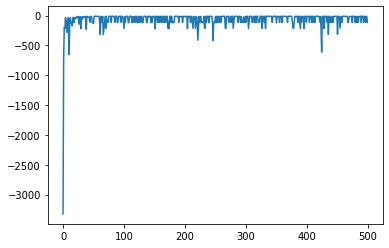

In [14]:
# Print the total reward for each episode (Q-Learning)

plt.plot(test_cliff.accumulated_rewards)

In [15]:
# Get the policy obtained (Q-Learning)

test_cliff.format_policy()
test_cliff.fpolicy

,0,1,2,3,4,5,6,7,8,9,10
0,⇢,⇡,⇢,⇡,⇢,⇣,⇢,⇢,⇣,⇢,⇣
1,⇣,⇣,⇢,⇣,⇣,⇣,⇢,⇣,⇣,⇣,⇣
2,⇢,⇢,⇢,⇢,⇢,⇢,⇢,⇢,⇢,⇢,⇣
3,⇡,⇡,⇡,⇡,⇡,⇡,⇡,⇡,⇡,⇢,⇡


In [16]:
# SARSA algorithm

sarsa_cliff = Cliff(algorithm='sarsa', nrows=4, ncols=11, gamma=1.0, alpha=0.5)
sarsa_cliff.do_iteration()

<ipython-input-12-2d24bc06b699>:209: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for episode in tqdm.tnrange(self.episodes):


  0%|          | 0/500 [00:00<?, ?it/s]

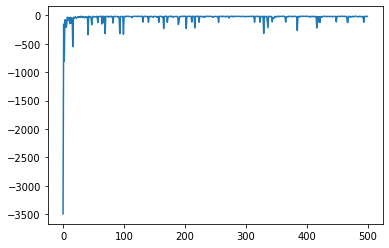

In [17]:
# Print the total reward for each episode (Sarsa)

plt.plot(sarsa_cliff.accumulated_rewards)

In [18]:
# Get the policy obtained (Sarsa)

sarsa_cliff.format_policy()
sarsa_cliff.fpolicy

,0,1,2,3,4,5,6,7,8,9,10
0,⇢,⇢,⇢,⇢,⇢,⇢,⇢,⇢,⇢,⇢,⇣
1,⇡,⇠,⇢,⇡,⇢,⇡,⇢,⇡,⇡,⇢,⇣
2,⇡,⇡,⇡,⇡,⇡,⇢,⇡,⇢,⇡,⇢,⇣
3,⇡,⇠,⇡,⇡,⇡,⇡,⇡,⇡,⇡,⇢,⇡
